In [823]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
from fuzzywuzzy import fuzz #conda install -c conda-forge fuzzywuzzy
sns.set_palette("husl")
rcParams['figure.figsize'] = 7,7
tweets = pd.read_csv('data/train.csv')
#vista previa de datos
tweets

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [824]:
tweets_text = tweets.loc[:,['text','target']]
tweets_text['target'] = tweets_text['target'] == 1
tweets_text

,text,target
0,Our Deeds are the Reason of this #earthquake M...,True
1,Forest fire near La Ronge Sask. Canada,True
2,All residents asked to 'shelter in place' are ...,True
3,"13,000 people receive #wildfires evacuation or...",True
4,Just got sent this photo from Ruby #Alaska as ...,True
...,...,...
7608,Two giant cranes holding a bridge collapse int...,True
7609,@aria_ahrary @TheTawniest The out of control w...,True
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,True
7611,Police investigating after an e-bike collided ...,True


# Cuál es la distribución entre tweets Reales y Falsos? 

Text(0.5, 0, 'Target')

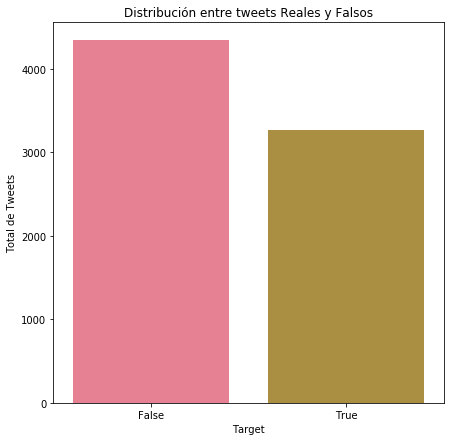

In [825]:
ax = sns.barplot(data = tweets_text.target.value_counts().reset_index(),x='index',y='target')
ax.set_title("Distribución entre tweets Reales y Falsos")
ax.set_ylabel("Total de Tweets")
ax.set_xlabel("Target")

# Pregunta: ¿Se puede establecer un conjunto de palabras que dado un tweet que contenga al menos una, indique si es real o falso?

Obtenemos las columnas de interés

Se crea un DataFrame con todas las palabras y sus frecuencias 

In [826]:
words = []
for x in tweets_text.text.tolist():
    for y in x.split(" "):
        words.append(y.lower())
df_words = pd.Series(words).value_counts().to_frame().reset_index()
df_words.columns = ['word','frecuency']

In [827]:
# Recibe las listas l1=[a1,a2,...,an] y l2=[b1,b2,...,bm] y las extiendea ambas a n x m elementos con la forma:
#  l1=[a1,...,a1,a2,...,a2,...,an,...,an] (m veces para cada elemento)
#  l2=[b1,b2,...,bm,b1,b2,...,bm] (n veces para cada m elementos)
#  Además devuelve una tercera lista con el producto cartesiano de las dos listas anteriores
def separate_cartesian_product_list(lenght_list, frecuency_list):
    first_list = lenght_list.copy()
    second_list = frecuency_list.copy()
    for x in range(len(second_list)-1):
        lenght_list.extend(first_list)
    lenght_list.sort()  
    for x in range(len(first_list)-1):
        frecuency_list.extend(second_list)
    
    third_list = []
    for x in first_list:
        for y in second_list:
            third_list.append((x,y))
    return third_list

Para determinar si existe un conjunto de palabras con las características deseadas, se realiza un count de cada palabra en todos los tweets. Luego, para achicar el conjunto se eligirá una longitud mínima y la frecuencia mínima de las palabras

In [828]:
#Se crean dos listas, la primera contiene todas las longitudes mínimas y la segunda contiene las frecuencias mínimas
#que se imponen para pertenecer al conjuto de palabras más frecuentes. 
#Se crea un dataframe donde cada registro determina un conjunto de palabras, ya que este contiene las variables antes 
#mencionadas y además una dupla con los mismos valores
word_lenght = list(range(1,10))
word_frecuency = list(range(10,140,5))

len_vs_fre = separate_cartesian_product_list(word_lenght,word_frecuency)
tweets_frec_len = pd.DataFrame({'lenght_min':word_lenght,'frecuency_min':word_frecuency, 'len_and_fre':len_vs_fre}) 


In [829]:
#Recibe un string y una colección de palabras, devuelve True en caso que al menos una de las palabras del string
#este contenida en la colección, Devuelve Falso para el caso contrario. 
def contain_long_words(s,long_words):
    for x in s.lower().split(" "):
        if x in long_words:
            return True
    return False

In [830]:
#Recibe una dupla de elementos: (longitud min,frecuencia min). devuelve el porcentaje de tweets reales de aquellos
#que continen al menos una palabra del conjunto de palabras mas frecuentes determinados por longitud min y frecuencia min
def get_true_percentage(x):
    long_words = df_words.loc[df_words['word'].transform(lambda y: len(y) >=  x[0])].loc[df_words.frecuency >= x[1],'word'].tolist()
    tweets_text['contain_long_word'] = tweets_text['text'].transform(lambda y: contain_long_words(y,long_words))
    tweets_contain_long_words = tweets_text.loc[tweets_text.contain_long_word == True,:]
    total_true =tweets_contain_long_words.loc[tweets_text.target == True,'target'].count()
    total_False = tweets_contain_long_words.loc[tweets_text.target == False,'target'].count()

    return total_true*100/(total_true +total_False)

El siguiente dataframe indica los porcentajes de tweets reales de aquellos que por lo menos una de sus palabras se encuentran en las palabras más frecuentes de logintud min y frecuencia min especificados

In [831]:
tweets_frec_len['true_percentage'] = tweets_frec_len['len_and_fre'].transform(lambda x: get_true_percentage(x)) 
data_for_heatmap =tweets_frec_len.drop(columns=['len_and_fre']).set_index(['frecuency_min','lenght_min']).unstack()
data_for_heatmap.columns = list(range(1,10))
data_for_heatmap


,1,2,3,4,5,6,7,8,9
frecuency_min,,,,,,,,,
10,43.118052,43.137515,43.209055,43.455427,44.424183,46.119426,48.717022,51.631617,55.107426
15,43.139073,43.168238,43.227358,43.426943,44.683908,46.715093,49.316651,51.925078,54.845361
20,43.158593,43.184239,43.258502,43.557019,45.283019,47.817869,50.135107,52.361981,55.550416
25,43.236039,43.256623,43.344617,43.862841,45.887246,48.774645,50.980392,53.036566,55.407565
30,43.234545,43.217708,43.238016,44.057377,47.525952,51.460778,55.363215,58.612770,64.050633
35,43.147824,43.154034,42.996191,44.012895,48.083624,52.951289,56.629393,62.515803,65.796345
40,43.156897,43.272777,43.074058,44.207511,49.178228,55.491744,60.400445,64.926740,67.706013
45,43.119391,43.235819,42.927608,44.186047,50.000000,57.843570,61.358656,68.414918,73.300971
50,43.143130,43.242499,42.850858,44.069807,51.133368,59.240759,64.690497,68.850267,71.774194


Text(114.0, 0.5, 'Frecuencia mínima de las palabras mas frecuentes')

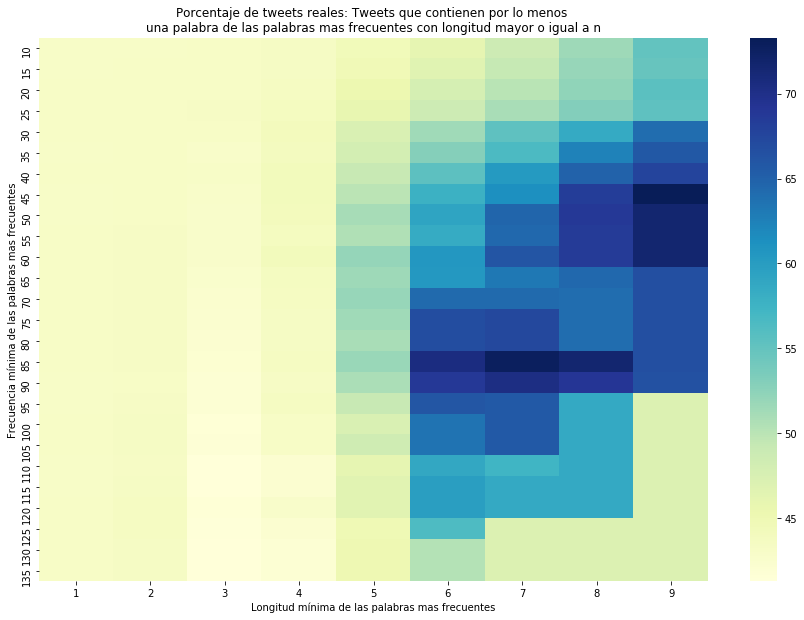

In [832]:
rcParams['figure.figsize'] = 15,10
heatmap = sns.heatmap(data_for_heatmap,cmap="YlGnBu")
heatmap.set_title("Porcentaje de tweets reales: Tweets que contienen por lo menos \nuna palabra de las palabras mas frecuentes con longitud mayor o igual a n")
heatmap.set_xlabel("Longitud mínima de las palabras mas frecuentes")
heatmap.set_ylabel("Frecuencia mínima de las palabras mas frecuentes")


El gráfico anterior nos permite acotar el conjunto de palabras, para lo cual se tomará aquellas palabras con longitud mínima de 5 y que posean una frecuencia minima de 30 ocurrencias. Luego, repetimos el proceso anterior pero por cada palabra para identificar aquellas que disminuyen el porcentaje de tweets reales 

In [833]:
def get_true_pertentage_word(x):
    x_list = []
    x_list.append(x)
    tweets_text['contain_long_word'] = tweets_text['text'].transform(lambda y: contain_long_words(y,x_list))
    tweets_contain_long_words = tweets_text.loc[tweets_text.contain_long_word == True,:]
    total_true =tweets_contain_long_words.loc[tweets_text.target == True,'target'].count()
    total_False = tweets_contain_long_words.loc[tweets_text.target == False,'target'].count()
    if (total_true +total_False) == False:
        print(x)
        print(tweets_contain_long_words)
    return total_true*100/(total_true +total_False),total_true

In [834]:
words_set = pd.DataFrame(df_words.loc[df_words['word'].transform(lambda y: len(y) >=  5)].loc[df_words.frecuency >= 30,'word'].tolist())
words_set['percentage_true'] = words_set[0].transform(lambda x: get_true_pertentage_word(x))
words_set['total_tweets_true'] = words_set['percentage_true'].transform(lambda x: x[1]).astype('int')
words_set['percentage_true'] = words_set['percentage_true'].transform(lambda x: x[0]).astype('int')


Se toman las palabras tienen más de un 75% de veracidad y que haya más de 30 de estos (este sería el conjunto de palabras buscados)

In [835]:
best_words = words_set.loc[words_set.percentage_true > 75].loc[words_set.total_tweets_true >30][0].tolist()


Se indica a cada tweet si contiene o no al menos una palabra de esta "bolsa de palabras"

In [836]:
tweets_text['contain_long_word'] = tweets_text['text'].transform(lambda y: contain_long_words(y,best_words))

Text(0.5, 0, 'Target')

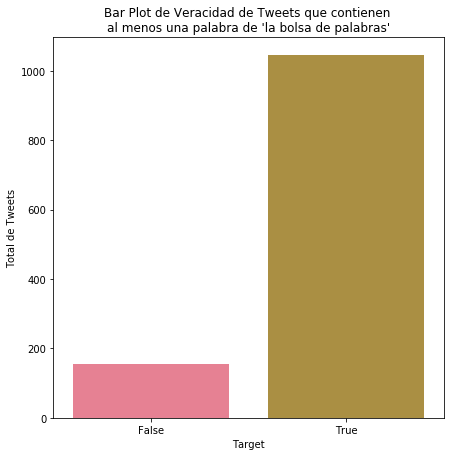

In [837]:
rcParams['figure.figsize'] = 7,7
ax = sns.barplot(data = tweets_text.loc[tweets_text['contain_long_word'] == True].target.value_counts().reset_index(),x='index',y='target')
ax.set_title("Bar Plot de Veracidad de Tweets que contienen \nal menos una palabra de 'la bolsa de palabras'")
ax.set_ylabel("Total de Tweets")
ax.set_xlabel("Target")


# Relación cantidad de palabras del tweet y veracidad

Se indica para cada tweet cuantas palabras posee el texto

In [838]:
tweets_text['total_words'] = tweets_text.text.transform(lambda x: len(x.split(" ")))


Text(0, 0.5, 'Frecuencia')

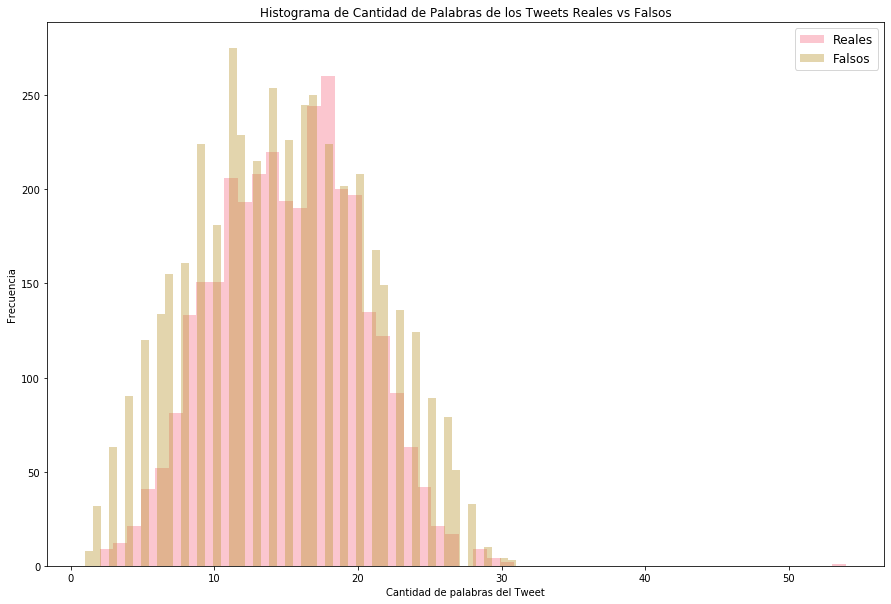

In [839]:
rcParams['figure.figsize'] = 15,10
sns.distplot(tweets_text.loc[tweets_text.target== True,'total_words'],  kde=False, label='Reales', bins = 54)
sns.distplot(tweets_text.loc[tweets_text.target== False,'total_words'],  kde=False, label='Falsos',bins = 54)
plt.legend(prop={'size': 12})
plt.title("Histograma de Cantidad de Palabras de los Tweets Reales vs Falsos")
plt.xlabel("Cantidad de palabras del Tweet")
plt.ylabel('Frecuencia')

# Relación entre la cantidad de caracteres y  veracidad del tweet

In [840]:
tweets_text['len_text'] = tweets_text.text.transform(lambda x: len(x))


Text(0, 0.5, 'Frecuencia')

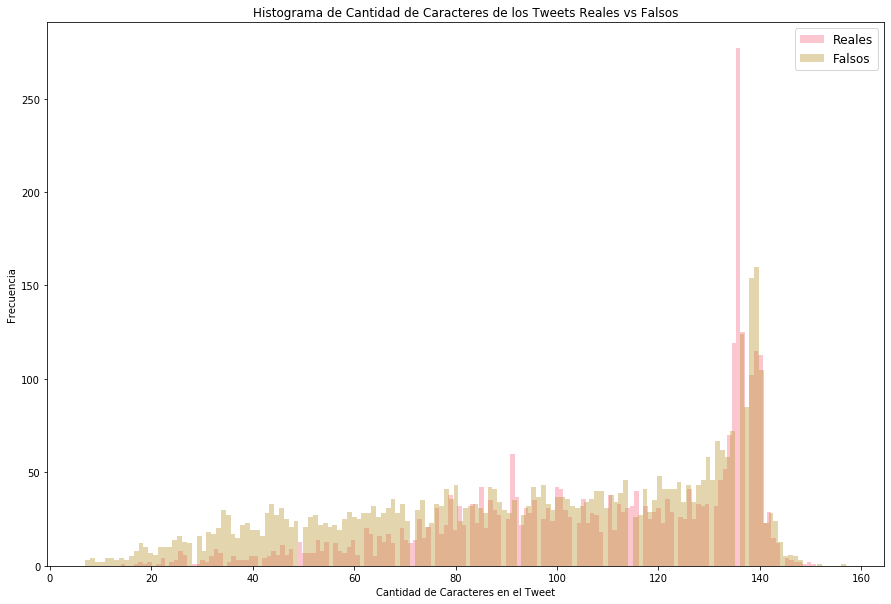

In [841]:
total_bins = tweets_text.len_text.max()
sns.distplot(tweets_text.loc[tweets_text.target== True,'len_text'],  kde=False, label='Reales', bins = total_bins)
sns.distplot(tweets_text.loc[tweets_text.target== False,'len_text'],  kde=False, label='Falsos',bins = total_bins)
plt.legend(prop={'size': 12})
plt.title("Histograma de Cantidad de Caracteres de los Tweets Reales vs Falsos")
plt.xlabel("Cantidad de Caracteres en el Tweet")
plt.ylabel('Frecuencia')

# Cuál es la correlación entre la cantidad de palabras del tweet y su longitud separados por target?

Text(26.93980577256945, 0.5, 'Total de Palabras')

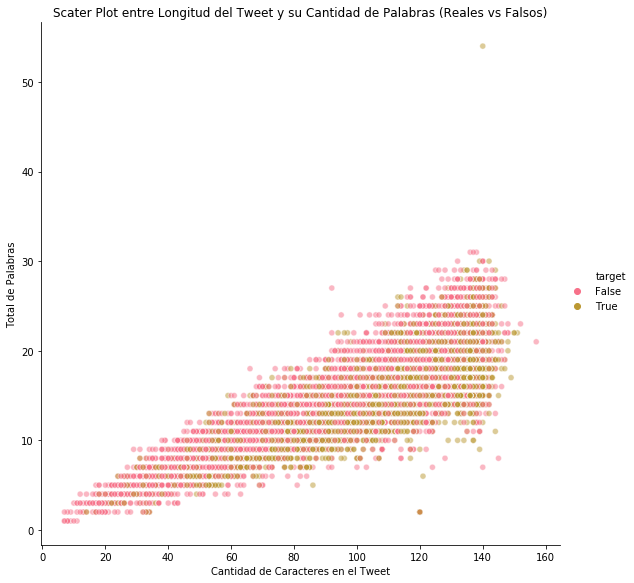

In [842]:
scater = sns.relplot(y="total_words", x="len_text", hue="target", alpha=.5,height=8, data=tweets_text)
plt.title("Scater Plot entre Longitud del Tweet y su Cantidad de Palabras (Reales vs Falsos)")
plt.xlabel("Cantidad de Caracteres en el Tweet")
plt.ylabel('Total de Palabras')

# Tomando en cuenta solo los tweets que contienen las palabras específicas

Text(26.93980577256945, 0.5, 'Total de Palabras')

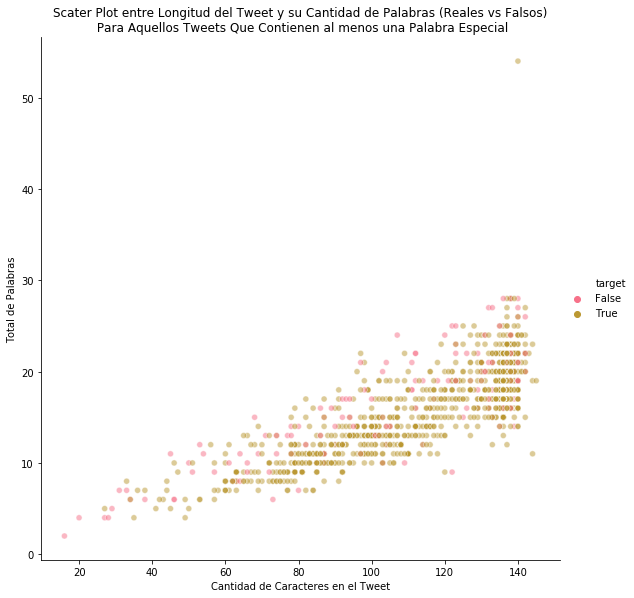

In [843]:
scater = sns.relplot(y="total_words", x="len_text", hue="target", alpha=.5,height=8, data=tweets_text.loc[tweets_text['contain_long_word'] == True])
plt.title("Scater Plot entre Longitud del Tweet y su Cantidad de Palabras (Reales vs Falsos)\n Para Aquellos Tweets Que Contienen al menos una Palabra Especial")
plt.xlabel("Cantidad de Caracteres en el Tweet")
plt.ylabel('Total de Palabras')

# Relación entre la cantidad de caracteres en mayusculas y la veracidad del tweet

In [844]:
#Recibe un string y devuelve la cantidad de caracteres en mayusculas que posee
def get_upper_total(s):
    total = 0
    for x in s:
        y = ord(x)
        if y > 90:
            continue
        if y > 64:
            total = total + 1
    return total

Se obtiene para cada tweet la cantidad de caracteres en mayusculas que posee el texto

In [845]:
tweets_text['total_upper_chars'] = tweets_text.text.transform(lambda x: get_upper_total(x))

Text(0, 0.5, 'Frecuencia')

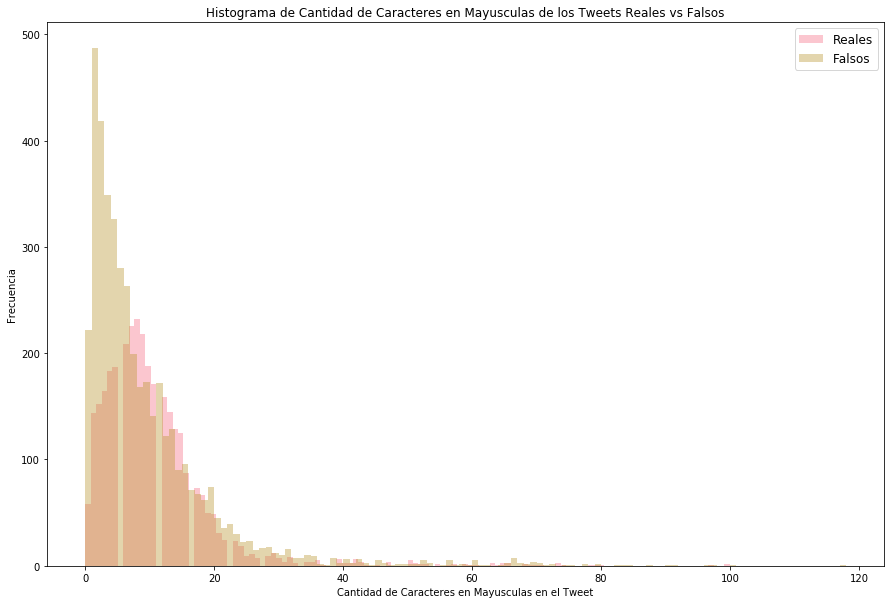

In [846]:
total_bins = tweets_text.total_upper_chars.max()
sns.distplot(tweets_text.loc[tweets_text.target== True,'total_upper_chars'],  kde=False, label='Reales', bins = total_bins)
sns.distplot(tweets_text.loc[tweets_text.target== False,'total_upper_chars'],  kde=False, label='Falsos',bins = total_bins)
plt.legend(prop={'size': 12})
plt.title("Histograma de Cantidad de Caracteres en Mayusculas de los Tweets Reales vs Falsos")
plt.xlabel("Cantidad de Caracteres en Mayusculas en el Tweet")
plt.ylabel('Frecuencia')

# Relación entre la cantidad de caracteres numéricos y la veracidad del tweet

In [847]:
#Recibe un string y devuelve la cantidad de caracteres numéricos que posee
def get_total_numbers_chars(s):
    total = 0
    for x in s:
        y = ord(x)
        if y in range(48,58):
            total = total + 1
    return total

Se obtiene para cada tweet la cantidad de caracteres numéricos que posee el texto

In [848]:
tweets_text['total_numbers_chars'] = tweets_text.text.transform(lambda x: get_total_numbers_chars(x))

Text(0, 0.5, 'Frecuencia')

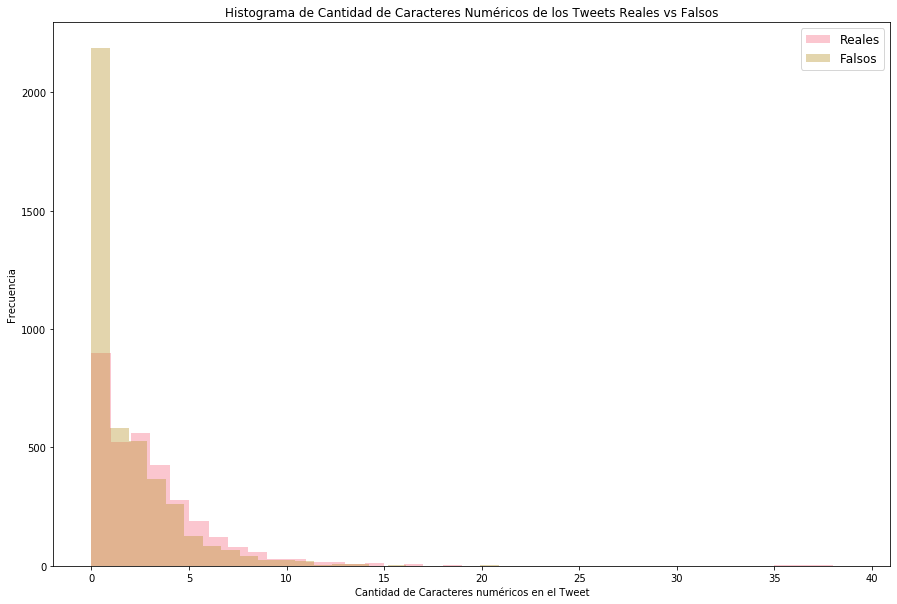

In [849]:
total_bins = tweets_text.total_numbers_chars.max()
sns.distplot(tweets_text.loc[tweets_text.target== True,'total_numbers_chars'],  kde=False, label='Reales', bins = total_bins)
sns.distplot(tweets_text.loc[tweets_text.target== False,'total_numbers_chars'],  kde=False, label='Falsos',bins = total_bins)
plt.legend(prop={'size': 12})
plt.title("Histograma de Cantidad de Caracteres Numéricos de los Tweets Reales vs Falsos")
plt.xlabel("Cantidad de Caracteres numéricos en el Tweet")
plt.ylabel('Frecuencia')

# Relación entre la cantidad de caracteres especiales y la veracidad del tweet


In [850]:
#Recibe un string y devuelve la cantidad de caracteres especiales que posee (excluye una lista de caracteres comunes)
def get_special_chars_total(s):
    total = 0
    common_esp_chr = [" ",".","?",",","!"]
    for x in s:
        y = ord(x)
        if y in range(97,123) or y in range(65,91) or y in range(48,58) or x in common_esp_chr:
            continue
        total = total + 1
    return total

Se obtiene para cada tweet la cantidad de caracteres especiales que posee el texto (sin incluir los mas comunes)

In [851]:
tweets_text['total_special_chars'] = tweets_text.text.transform(lambda x: get_special_chars_total(x))

Text(0, 0.5, 'Frecuencia')

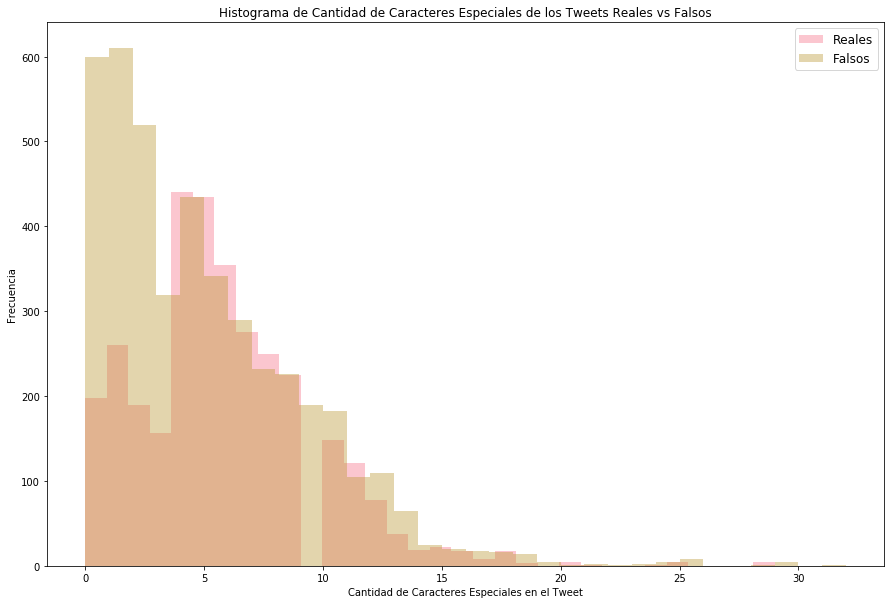

In [852]:
total_bins = tweets_text.total_special_chars.max()
sns.distplot(tweets_text.loc[tweets_text.target== True,'total_special_chars'],  kde=False, label='Reales', bins = total_bins)
sns.distplot(tweets_text.loc[tweets_text.target== False,'total_special_chars'],  kde=False, label='Falsos',bins = total_bins)
plt.legend(prop={'size': 12})
plt.title("Histograma de Cantidad de Caracteres Especiales de los Tweets Reales vs Falsos")
plt.xlabel("Cantidad de Caracteres Especiales en el Tweet")
plt.ylabel('Frecuencia')


# Cómo se correlacionan la cantidad de caracteres numéricos, en mayusculas y especiales separados por target?

Text(30.49235387731482, 0.5, 'Cantidad de Caracteres Numéricos')

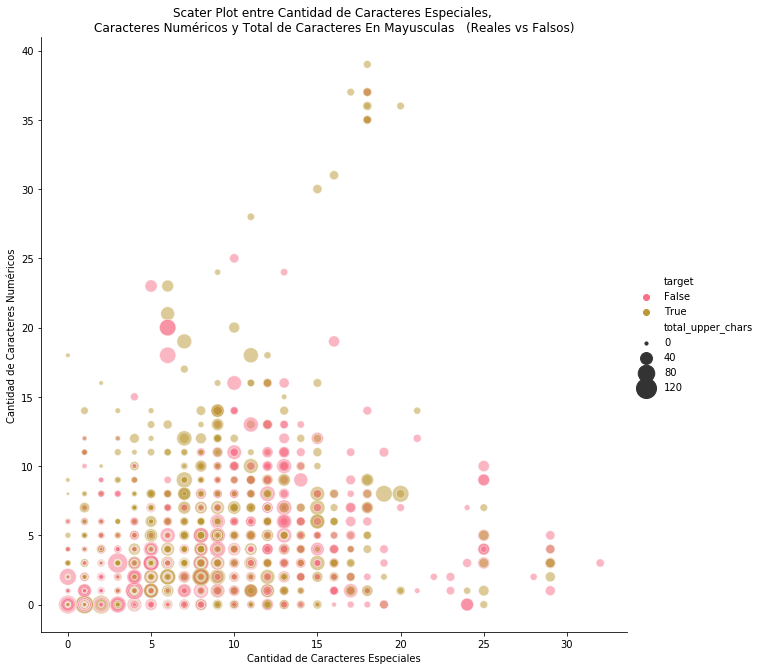

In [853]:
scater = sns.relplot(size="total_upper_chars", y="total_numbers_chars", hue="target", x= 'total_special_chars',alpha = 0.5,height=9, data=tweets_text,sizes=(10,400))
plt.title("Scater Plot entre Cantidad de Caracteres Especiales, \nCaracteres Numéricos y Total de Caracteres En Mayusculas   (Reales vs Falsos)")
plt.xlabel("Cantidad de Caracteres Especiales")
plt.ylabel('Cantidad de Caracteres Numéricos')


# Cuál es la correlación entre cada par de variables?

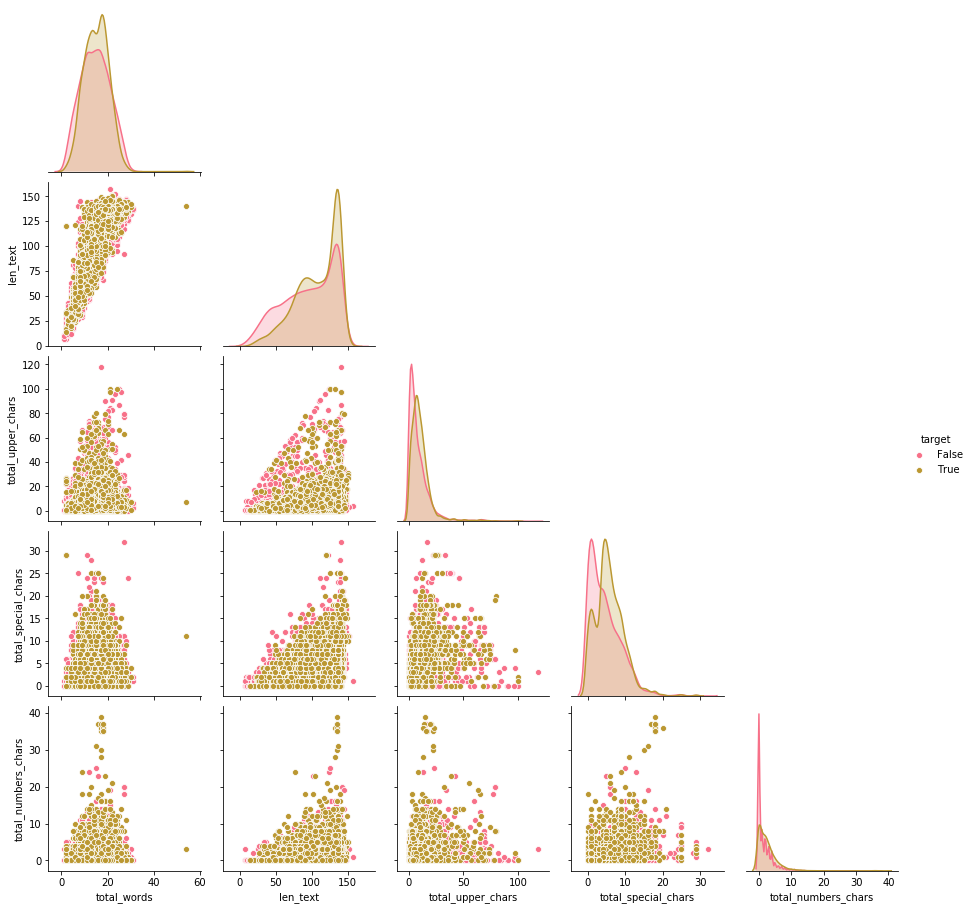

In [854]:
pair = sns.pairplot(hue='target',data= tweets_text.loc[:,['target','total_words','len_text','total_upper_chars','total_special_chars','total_numbers_chars']],corner=True)



# Existen preguntas en los tweets ? como se relacionan estas con su veracidad

Indicamos para cada tweet si posee o no una pregunta (se asume que la posee si contiene el caracter "?")

In [855]:
tweets_text['contain_question'] = tweets_text.text.transform(lambda x: "?" in x)

Text(0.5, 0, 'Target')

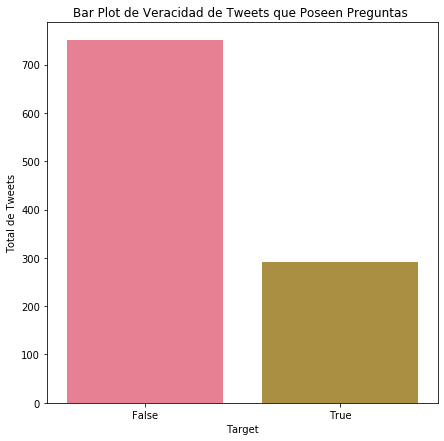

In [856]:
rcParams['figure.figsize'] = 7,7
ax = sns.barplot(data = tweets_text.loc[tweets_text.contain_question == True].target.value_counts().reset_index(),x='index',y='target')
ax.set_title("Bar Plot de Veracidad de Tweets que Poseen Preguntas ")
ax.set_ylabel("Total de Tweets")
ax.set_xlabel("Target")


# Cómo se relaciona los tweets que poseen  enlaces con su veracidad?

Indicamos para cada tweet si posee o no un enlace (se asume que la posee si contiene "http")

In [857]:
tweets_text['contain_link'] = tweets_text.text.transform(lambda x: "http" in x)

Text(0.5, 0, 'Target')

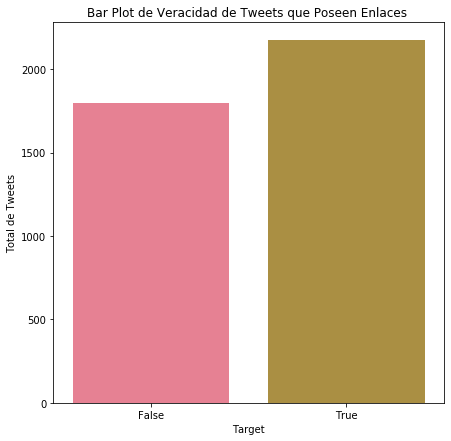

In [858]:
ax = sns.barplot(data = tweets_text.loc[tweets_text.contain_link == True].target.value_counts().reset_index(),x='index',y='target')
ax.set_title("Bar Plot de Veracidad de Tweets que Poseen Enlaces ")
ax.set_ylabel("Total de Tweets")
ax.set_xlabel("Target")

# Cómo varían los resultados anteriores para el top 9 de desastres con más tweets?

In [859]:
tweets_text_key = tweets.loc[:,['text','keyword','target']].dropna()

Agrupación de keyword por similitud

In [ ]:
#Recibe una lista de keywords y regresa un diccionario cuyas claves son los elementos de la lista pasada y los valores
#son las keywords agrupadas que las representa
def get_keyword_dic(key_list):
    key_dic = {}
    unique_list = []
    for x in key_list:
        z = x
        if "%20" in x:
            z = " ".join(x.split("%20"))
        similarity = 0
        value = ""
        for y in unique_list:
            ratio = fuzz.ratio(z,y)
            if ratio > similarity:
                similarity = ratio
                value = y
        if similarity > 75:
            key_dic[x] = value
        else:
            key_dic[x] = z
            unique_list.append(z)
    return key_dic
key_grouped = get_keyword_dic(tweets_text_key.keyword.tolist())

Agrupoamiento manual

In [ ]:
key_grouped['blazing'] = 'ablaze'
key_grouped['bleeding'] = 'blood'
key_grouped['buildings%20on%20fire'] = 'buildings burning'
key_grouped['burning%20buildings'] = 'buildings burning'
key_grouped['burning'] = 'burned'
key_grouped['dead'] = 'death'
key_grouped['demolition'] = 'demolish'
key_grouped['destruction'] = 'destroy'
key_grouped['explosion'] = 'explode'
key_grouped['flood'] = 'flooding'
key_grouped['floods'] = 'flooding'
key_grouped['inundated'] = 'inundation'
key_grouped['panic'] = 'panicking'
key_grouped['rainstorm'] = 'rainstorm'
key_grouped['riot'] = 'rioting'
key_grouped['screaming'] = 'screamed'
key_grouped['snowstorm'] = 'snowstorm'
key_grouped['survivors'] = 'survive'
key_grouped['traumatised'] = 'trauma'
key_grouped['violent%20storm'] = 'storm'
key_grouped['windstorm'] = 'storm'
key_grouped['traumatised'] = 'trauma'

Se agrupan algunas de las keyword y solo nos quedamos con el top15 (por cantidad de tweets)

In [ ]:
tweets_text_key['target'] = tweets_text['target'] == 1
tweets_text_key['keyword_grouped'] = tweets_text_key.keyword.transform(lambda x: key_grouped[x])
key_list_top = tweets_text_key.keyword_grouped.value_counts().nlargest(15).index
tweets_text_key['keyword_top'] = tweets_text_key.keyword_grouped.transform(lambda x: x in key_list_top)
tweets_text_key_top = tweets_text_key.loc[tweets_text_key.keyword_top].copy()
tweets_text_key_top


# Existen preguntas en los tweets del top 15 por tipo de desastre? como se relacionan estas con su veracidad

In [ ]:
tweets_text_key_top['contain_question'] = tweets_text_key_top.text.transform(lambda x: "?" in x)

In [ ]:
rcParams['figure.figsize'] = 15,10

sns.set_color_codes("pastel")
data= tweets_text_key_top.loc[tweets_text_key_top.contain_question == True].groupby(['keyword_grouped']).agg({'text':['count'],'target':['sum']}).reset_index().sort_values(by=('text','count'),ascending=False)
sns.barplot(data = data,y='keyword_grouped',x=('text','count'), color="b",label= 'Total Tweets')

sns.set_color_codes("muted")
ax = sns.barplot(data = data,y='keyword_grouped',x=('target','sum'), color="b",label= 'Total Tweets True')
ax.set_title("Tweets que Poseen preguntas separados por tipo de desastre (Reales vs Total)")
ax.set_xlabel("Total de Tweets")
ax.set_ylabel("Keyword")

ax.legend(ncol=2, loc="lower right", frameon=True)


# Cómo se relaciona los tweets del top 15 por tipo de desastre que poseen  enlaces con su veracidad?

In [ ]:
tweets_text_key_top['contain_link'] = tweets_text_key_top.text.transform(lambda x: "http" in x)

In [ ]:
sns.set_color_codes("pastel")
data= tweets_text_key_top.loc[tweets_text_key_top.contain_link == True].groupby(['keyword_grouped']).agg({'text':['count'],'target':['sum']}).reset_index().sort_values(by=('text','count'),ascending=False)
sns.barplot(data = data,y='keyword_grouped',x=('text','count'), color="b",label= 'Total Tweets')

sns.set_color_codes("muted")
ax = sns.barplot(data = data,y='keyword_grouped',x=('target','sum'), color="b",label= 'Total Tweets True')
ax.set_title("Tweets que Poseen preguntas Enlaces por tipo de desastre (Reales vs Total)")
ax.set_xlabel("Total de Tweets")
ax.set_ylabel("Keyword")
ax.legend(ncol=2, loc="lower right", frameon=True)


# Relación entre la cantidad de caracteres en mayusculas y la veracidad del tweet del Top 9

In [ ]:
key_list_top = tweets_text_key.keyword_grouped.value_counts().nlargest(9).index
tweets_text_key['keyword_top'] = tweets_text_key.keyword_grouped.transform(lambda x: x in key_list_top)
tweets_text_key_top = tweets_text_key.loc[tweets_text_key.keyword_top].copy()
tweets_text_key_top['total_upper_chars'] = tweets_text_key_top.text.transform(lambda x: get_upper_total(x))

In [ ]:
keyword_list = tweets_text_key_top.keyword_grouped.unique().tolist()
f, ax = plt.subplots(3, 3, figsize=(15, 15))
i = 0
for x in ax:
    for y in x:
        data_true = tweets_text_key_top.loc[tweets_text_key_top.keyword_grouped==keyword_list[i]].loc[tweets_text_key_top.target== True,'total_upper_chars']
        data_false = tweets_text_key_top.loc[tweets_text_key_top.keyword_grouped==keyword_list[i]].loc[tweets_text_key_top.target== False,'total_upper_chars']
        sns.distplot(data_false,  kde=False, label='Falsos',ax=y)
        sns.distplot(data_true,  kde=False, label='Reales',ax=y)
        #y.set_title("Histograma de Longitudes de los \n Tweets Cortos Reales vs Falsos")
        y.set_xlabel(keyword_list[i])
        i = i+1
    x[0].set_ylabel("Frecuencia")
    x[2].legend(prop={'size': 10})
ax[0][1].set_title("Histogramas de Cantidad de Caracterres en Mayusculas Reales vs Falsos, \nEn los Principales Desastres")


# Cómo es la distribución de los tweets según las variables relacionadas al texto vistas anteriormente?

In [ ]:
tweets_text_key_top['total_words'] = tweets_text_key_top.text.transform(lambda x: len(x.split(" ")))
tweets_text_key_top['len_text'] = tweets_text_key_top.text.transform(lambda x: len(x))
tweets_text_key_top['total_numbers_chars'] = tweets_text_key_top.text.transform(lambda x: get_total_numbers_chars(x))
tweets_text_key_top['total_special_chars'] = tweets_text_key_top.text.transform(lambda x: get_special_chars_total(x))


In [ ]:
rcParams['figure.figsize'] = 15,10
violin_plt=sns.violinplot(x="keyword_grouped", y="total_upper_chars", hue="target",split=True,data=tweets_text_key_top)
violin_plt.set_title("Distribución de los Tweets según la Cantidad de Caracteres en Mayusculas Separados por Tipo de Desastre y Veracidad")
violin_plt.set_ylabel("Total de Tweets")
violin_plt.set_xlabel("Tipo de Desastre")


In [ ]:
violin_plt=sns.violinplot(x="keyword_grouped", y="len_text", hue="target",split=True,data=tweets_text_key_top)
violin_plt.set_title("Distribución de los Tweets según Logitud del Tweet Separados por Tipo de Desastre y Veracidad")
violin_plt.set_ylabel("Total de Tweets")
violin_plt.set_xlabel("Tipo de Desastre")

In [ ]:
violin_plt=sns.violinplot(x="keyword_grouped", y="total_words", hue="target",split=True,data=tweets_text_key_top)
violin_plt.set_title("Distribución de los Tweets según Cantidad de Palabras Separados por Tipo de Desastre y Veracidad")
violin_plt.set_ylabel("Total de Tweets")
violin_plt.set_xlabel("Tipo de Desastre")

In [ ]:
violin_plt=sns.violinplot(x="keyword_grouped", y="total_numbers_chars", hue="target",split=True,data=tweets_text_key_top)
violin_plt.set_title("Distribución de los Tweets según Cantidad Caracteres Numéricos Separados por Tipo de Desastre y Veracidad")
violin_plt.set_ylabel("Total de Tweets")
violin_plt.set_xlabel("Tipo de Desastre")

In [ ]:
violin_plt=sns.violinplot(x="keyword_grouped", y="total_special_chars", hue="target",split=True,data=tweets_text_key_top)
violin_plt.set_title("Distribución de los Tweets según Cantidad Caracteres Especiales Separados por Tipo de Desastre y Veracidad")
violin_plt.set_ylabel("Total de Tweets")
violin_plt.set_xlabel("Tipo de Desastre")